In [ ]:
# Exporting the notebook. It may take several seconds....

[NbConvertApp] Converting notebook demo_predictive_maintenance.ipynb to script
[NbConvertApp] Writing 14379 bytes to demo_predictive_maintenance.py


autofeat==1.1.3
numpy==1.18.5
xgboost==1.2.1
Keras==2.4.3
pandas==0.25.3
seaborn==0.9.0
tensorflow==2.3.1
matplotlib==3.0.2
scikit_learn==0.23.2


INFO: Successfully output requirements


## Data connection

In [138]:
# # import required libraries
# from xpresso.ai.core.data.automl import StructuredDataset

# # create a structured dataset
# my_dataset = StructuredDataset(dataset_name = "turbofan", project_name = "predictive_maintenance", created_by = "sunit.sushil")

# # set parameters for importing a local CSV file
# data_config = {"type": "FS",
#                "data_source": "Local",
#                "options": {"sep": " ", "header": None},
#                "path": "/home/jovyan/predictive_maintenance/train_FD001_exp.txt"}

# # import data from a CSV file into the dataset
# my_dataset.import_dataset(data_config)

# # data variable of dataset is a pandas data frame
# my_dataset.data.shape
# data_frame = my_dataset.data.head()
# data_frame

## Data preprocessing

In [139]:
# my_dataset.data = my_dataset.data.drop(my_dataset.data.columns[[26, 27]], axis = 1) # dropping last two NaN columns
# my_dataset.data.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#                      's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#                      's15', 's16', 's17', 's18', 's19', 's20', 's21']
# my_dataset.data

## Versioning - Raw dataset

In [140]:
# from xpresso.ai.core.data.versioning.controller_factory import VersionControllerFactory

# # Create a Repo Manager object
# repo_manager = VersionControllerFactory().get_version_controller()

In [141]:
# # A repository for the project would already have been created
# # create a branch within the repo
# repo_manager.create_branch(repo_name="predictive_maintenance", branch_name="raw_dataset", branch_type="data")

In [142]:
# #push the dataset
# repo_manager.push_dataset(repo_name="predictive_maintenance", branch_name="raw_dataset",  
#                           dataset=my_dataset, description="Version raw dataset", branch_type="data")

In [143]:
# #list datasets in the branch to ensure the dataset has been pushed correctly
# repo_manager.list_dataset(repo_name="predictive_maintenance", branch_name="raw_dataset", show_table=True)

## Exploration

In [144]:
# from xpresso.ai.core.data.exploration import Explorer

# # create a data explorer
# explorer = Explorer(my_dataset)

# explorer.understand()
# explorer.explore_univariate(verbose=True)
# explorer.explore_multivariate(verbose=True)

## Visualization - report generation

In [145]:
# #import required libraries
# from xpresso.ai.core.data.visualization import Visualization

# #instantiate a Visualization object
# visualizer = Visualization.get_visualizer(my_dataset)

In [146]:
# visualizer.render_all(report=True)

## ML pipeline code (auto-project)

## data_fetch

In [147]:
## $xpr_param_component_name = data_fetch
## $xpr_param_component_type = pipeline_job

In [148]:
import os
#import pandas as pd
import pandas
#import numpy as np
import numpy 
import matplotlib
import tensorflow
#import matplotlib.pyplot as plt
import matplotlib.pyplot
#import seaborn as sns
import seaborn
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

## data_prep

In [149]:
## $xpr_param_component_name = data_prep
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization","data_extraction","data_cleaning"]

In [184]:
path = "/data/turbofan"
#path = "/home/jovyan/predictive_maintenance/pipelines/pm-pipeline"
train_files = ['train_FD001.txt']
train_file = train_files[0]

In [151]:
def data_extraction(file):
    import pandas
    df = pandas.read_csv(os.path.join(path, file), sep = ' ', header = None)
    print("Shape of training data: ",df.shape)
    return df

In [152]:
def data_cleaning(dataframe):
    dataframe_modified = dataframe.drop(dataframe.columns[[26, 27]], axis = 1) # dropping last two NaN columns
    dataframe_modified.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    
    # Calculating the RUL (Remaining Useful Life) for each id
    rul = pandas.DataFrame(dataframe_modified.groupby('id')['cycle'].max()).reset_index() # max cycles for each id
    rul.columns = ['id', 'maxCycles'] 
    train_df = dataframe_modified.merge(rul, on=['id'], how='left') 
    train_df['RUL'] = train_df['maxCycles'] - train_df['cycle']
    train_df.drop('maxCycles', axis=1, inplace=True) 
    return train_df

In [153]:
# Extracting data
df_initial = data_extraction(train_file)

Shape of training data:  (20631, 28)


In [154]:
# Removing columns with NaN and adding the RUL column
df_cleaned = data_cleaning(df_initial)
df_cleaned

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1        1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2        1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3        1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4        1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   
...    ...    ...       ...       ...       ...     ...     ...      ...   
20626  100    196   -0.0004   -0.0003     100.0  518.67  643.49  1597.98   
20627  100    197   -0.0016   -0.0005     100.0  518.67  643.54  1604.50   
20628  100    198    0.0004    0.0000     100.0  518.67  643.42  1602.46   
20629  100    199   -0.0011    0.0003     100.0  518.67  643.23  1605.26   
20630  100    200   -0.0032   -0.0005     100.0  518.67  643.85  1600.38   

            s4     s5  ...      s13      s14     s15   s16  s17   s18    s19  \
0      1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1      1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2      1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3      1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4      1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
...        ...    ...  ...      ...      ...     ...   ...  ...   ...    ...   
20626  1428.63  14.62  ...  2388.26  8137.60  8.4956  0.03  397  2388  100.0   
20627  1433.58  14.62  ...  2388.22  8136.50  8.5139  0.03  395  2388  100.0   
20628  1428.18  14.62  ...  2388.24  8141.05  8.5646  0.03  398  2388  100.0   
20629  1426.53  14.62  ...  2388.23  8139.29  8.5389  0.03  395  2388  100.0   
20630  1432.14  14.62  ...  2388.26  8137.33  8.5036  0.03  396  2388  100.0   

         s20      s21  RUL  
0      39.06  23.4190  191  
1      39.00  23.4236  190  
2      38.95  23.3442  189  
3      38.88  23.3739  188  
4      38.90  23.4044  187  
...      ...      ...  ...  
20626  38.49  22.9735    4  
20627  38.30  23.1594    3  
20628  38.44  22.9333    2  
20629  38.29  23.0640    1  
20630  38.37  23.0522    0  

[20631 rows x 27 columns]

## feature_engineering

In [155]:
## $xpr_param_component_name = feature_engineering
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization","data_extraction","data_cleaning"]

In [185]:
path = "/data/turbofan"
#path = "/home/jovyan/predictive_maintenance/pipelines/pm-pipeline"
train_files = ['train_FD001.txt']
train_file = train_files[0]

In [157]:
def data_extraction(file):
    import pandas
    df = pandas.read_csv(os.path.join(path, file), sep = ' ', header = None)
    print("Shape of training data: ",df.shape)
    return df

In [158]:
def data_cleaning(dataframe):
    dataframe_modified = dataframe.drop(dataframe.columns[[26, 27]], axis = 1) # dropping last two NaN columns
    dataframe_modified.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    
    # Calculating the RUL (Remaining Useful Life) for each id
    rul = pandas.DataFrame(dataframe_modified.groupby('id')['cycle'].max()).reset_index() # max cycles for each id
    rul.columns = ['id', 'maxCycles'] 
    train_df = dataframe_modified.merge(rul, on=['id'], how='left') 
    train_df['RUL'] = train_df['maxCycles'] - train_df['cycle']
    train_df.drop('maxCycles', axis=1, inplace=True) 
    return train_df

In [159]:
# Extracting data
df_initial = data_extraction(train_file)

Shape of training data:  (20631, 28)


In [160]:
# Removing columns with NaN and adding the RUL column
df_cleaned = data_cleaning(df_initial)
df_cleaned

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1        1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2        1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3        1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4        1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   
...    ...    ...       ...       ...       ...     ...     ...      ...   
20626  100    196   -0.0004   -0.0003     100.0  518.67  643.49  1597.98   
20627  100    197   -0.0016   -0.0005     100.0  518.67  643.54  1604.50   
20628  100    198    0.0004    0.0000     100.0  518.67  643.42  1602.46   
20629  100    199   -0.0011    0.0003     100.0  518.67  643.23  1605.26   
20630  100    200   -0.0032   -0.0005     100.0  518.67  643.85  1600.38   

            s4     s5  ...      s13      s14     s15   s16  s17   s18    s19  \
0      1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1      1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2      1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3      1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4      1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
...        ...    ...  ...      ...      ...     ...   ...  ...   ...    ...   
20626  1428.63  14.62  ...  2388.26  8137.60  8.4956  0.03  397  2388  100.0   
20627  1433.58  14.62  ...  2388.22  8136.50  8.5139  0.03  395  2388  100.0   
20628  1428.18  14.62  ...  2388.24  8141.05  8.5646  0.03  398  2388  100.0   
20629  1426.53  14.62  ...  2388.23  8139.29  8.5389  0.03  395  2388  100.0   
20630  1432.14  14.62  ...  2388.26  8137.33  8.5036  0.03  396  2388  100.0   

         s20      s21  RUL  
0      39.06  23.4190  191  
1      39.00  23.4236  190  
2      38.95  23.3442  189  
3      38.88  23.3739  188  
4      38.90  23.4044  187  
...      ...      ...  ...  
20626  38.49  22.9735    4  
20627  38.30  23.1594    3  
20628  38.44  22.9333    2  
20629  38.29  23.0640    1  
20630  38.37  23.0522    0  

[20631 rows x 27 columns]

In [161]:
def create_training_and_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

In [162]:
def normalization(X_train, X_test):
    scaler = QuantileTransformer(n_quantiles=10, output_distribution='normal')
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

In [163]:
def feature_engineering(dataframe):
    dataframe_description = dataframe.describe()
    df_plot = dataframe.copy()
    df_corr = df_plot.corr(method='pearson')
    fig, ax = matplotlib.pyplot.subplots(figsize=(10,10))
    axes = seaborn.heatmap(df_corr, linewidths=.2)
    axes = dataframe_description.T.plot.bar(subplots=True, figsize=(20,15))
    data = dataframe.drop(['cycle','id'], axis=1)
    
    X = (data.iloc[:,:-1]).to_numpy()
    y = (data.iloc[:,-1]).to_numpy()
    
    #Creating training and test data
    X_train, X_test, y_train, y_test = create_training_and_test_data(X, y)
    
    #Normalizing train and test data
    X_train_normalized, X_test_normalized = normalization(X_train, X_test)
    
    #Feature Engineering using autofeat
    afreg = AutoFeatRegressor(verbose=1, feateng_steps = 1, featsel_runs = 1)
    X_train_transformed = afreg.fit_transform(X_train_normalized, y_train)
    X_test_transformed = afreg.transform(X_test_normalized)
    print("R^2 after feature engineering: %.4f" % afreg.score(X_test_transformed, y_test))  
    X_train_transformed = X_train_transformed.to_numpy()
    X_test_transformed = X_test_transformed.to_numpy()
    return X_train_transformed, X_test_transformed, y_train, y_test

[AutoFeat] The 1 step feature engineering process could generate up to 168 features.
[AutoFeat] With 16504 data points this new feature matrix would use about 0.01 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 74 transformed features from 24 original features - done.
[feateng] Generated altogether 74 new features in 1 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 74 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/1
[featsel] 16 features after 1 feature selection runs
[featsel] 16 features after correlation filtering
[featsel] 15 features after noise filtering
[AutoFeat] Computing 3 new features.
[AutoFeat]     3/    3 new features ...done.
[AutoFeat] Final dataframe with 27 feature columns (3 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
124.82690407986628
-12.416383 * x013
-10.428244 *

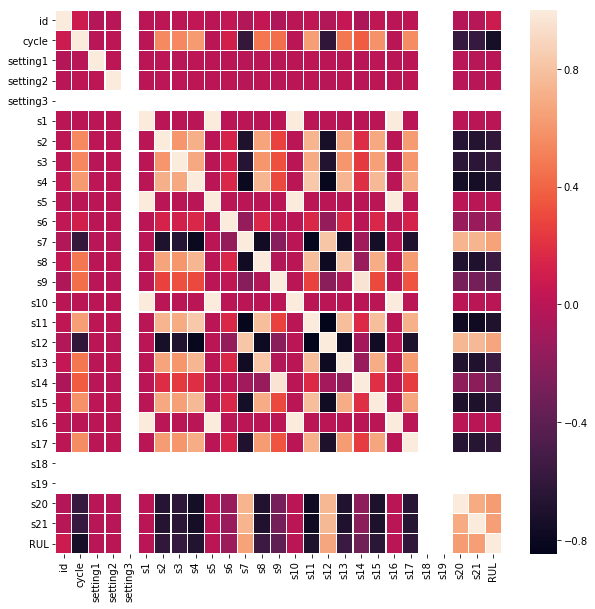

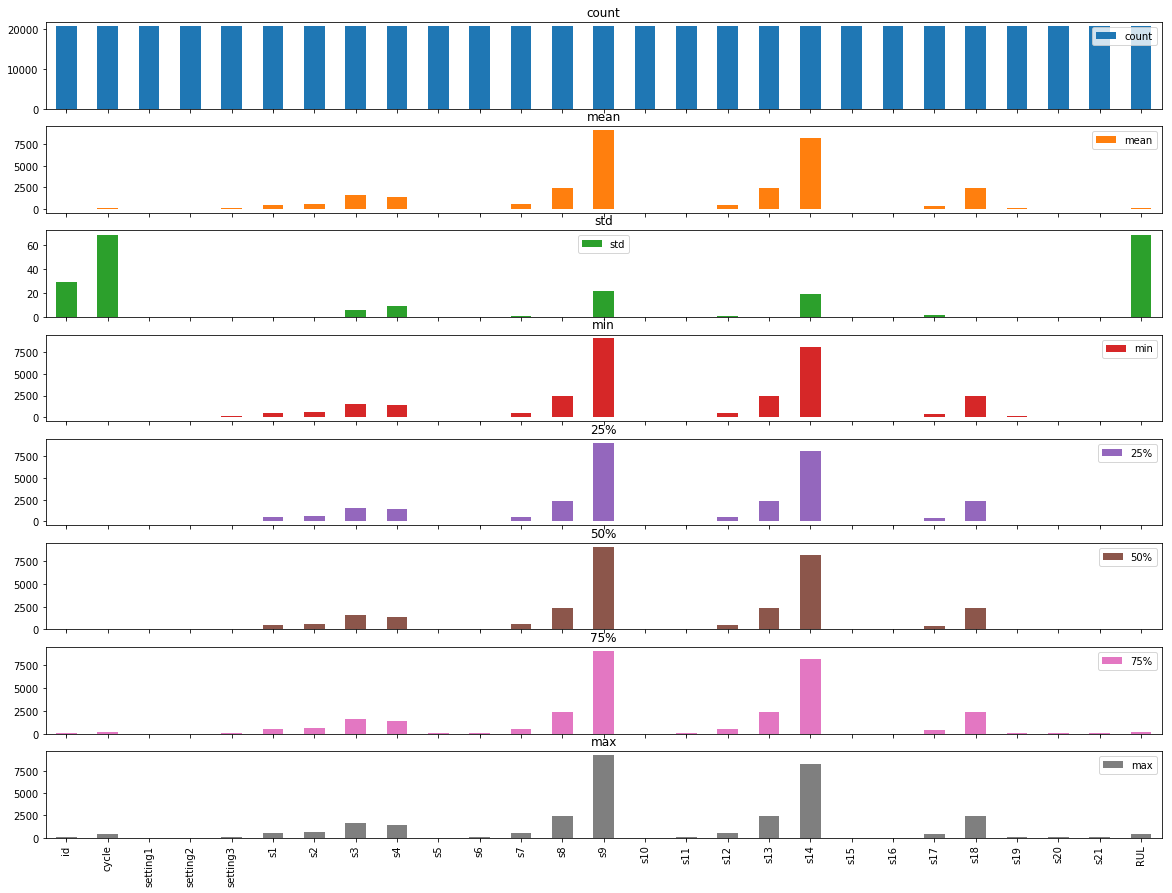

In [164]:
# Train-test split, normalization and feature engineering
X_train_transformed, X_test_transformed, y_train, y_test = feature_engineering(df_cleaned)

## Training

In [165]:
## $xpr_param_component_name = training
## $xpr_param_component_type = pipeline_job
## $xpr_param_global_variables = ["train_file"]
## $xpr_param_global_methods = ["create_training_and_test_data", "normalization","data_extraction","data_cleaning","feature_engineering"]

In [186]:
path = "/data/turbofan"
#path = "/home/jovyan/predictive_maintenance/pipelines/pm-pipeline"
train_files = ['train_FD001.txt']
train_file = train_files[0]

In [167]:
def data_extraction(file):
    import pandas
    df = pandas.read_csv(os.path.join(path, file), sep = ' ', header = None)
    print("Shape of training data: ",df.shape)
    return df

In [168]:
def data_cleaning(dataframe):
    dataframe_modified = dataframe.drop(dataframe.columns[[26, 27]], axis = 1) # dropping last two NaN columns
    dataframe_modified.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    
    # Calculating the RUL (Remaining Useful Life) for each id
    rul = pandas.DataFrame(dataframe_modified.groupby('id')['cycle'].max()).reset_index() # max cycles for each id
    rul.columns = ['id', 'maxCycles'] 
    train_df = dataframe_modified.merge(rul, on=['id'], how='left') 
    train_df['RUL'] = train_df['maxCycles'] - train_df['cycle']
    train_df.drop('maxCycles', axis=1, inplace=True) 
    return train_df

In [169]:
# Extracting data
df_initial = data_extraction(train_file)

Shape of training data:  (20631, 28)


In [170]:
# Removing columns with NaN and adding the RUL column
df_cleaned = data_cleaning(df_initial)


In [171]:
def create_training_and_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

In [172]:
def normalization(X_train, X_test):
    scaler = QuantileTransformer(n_quantiles=10, output_distribution='normal')
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

In [173]:
def feature_engineering(dataframe):
    dataframe_description = dataframe.describe()
    df_plot = dataframe.copy()
    df_corr = df_plot.corr(method='pearson')
    fig, ax = matplotlib.pyplot.subplots(figsize=(10,10))
    axes = seaborn.heatmap(df_corr, linewidths=.2)
    axes = dataframe_description.T.plot.bar(subplots=True, figsize=(20,15))
    data = dataframe.drop(['cycle','id'], axis=1)
    
    X = (data.iloc[:,:-1]).to_numpy()
    y = (data.iloc[:,-1]).to_numpy()
    
    #Creating training and test data
    X_train, X_test, y_train, y_test = create_training_and_test_data(X, y)
    
    #Normalizing train and test data
    X_train_normalized, X_test_normalized = normalization(X_train, X_test)
    
    #Feature Engineering using autofeat
    afreg = AutoFeatRegressor(verbose=1, feateng_steps = 1, featsel_runs = 1)
    X_train_transformed = afreg.fit_transform(X_train_normalized, y_train)
    X_test_transformed = afreg.transform(X_test_normalized)
    print("R^2 after feature engineering: %.4f" % afreg.score(X_test_transformed, y_test))  
    X_train_transformed = X_train_transformed.to_numpy()
    X_test_transformed = X_test_transformed.to_numpy()
    return X_train_transformed, X_test_transformed, y_train, y_test

[AutoFeat] The 1 step feature engineering process could generate up to 168 features.
[AutoFeat] With 16504 data points this new feature matrix would use about 0.01 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 74 transformed features from 24 original features - done.
[feateng] Generated altogether 74 new features in 1 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 74 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/1
[featsel] 16 features after 1 feature selection runs
[featsel] 16 features after correlation filtering
[featsel] 15 features after noise filtering
[AutoFeat] Computing 3 new features.
[AutoFeat]     3/    3 new features ...done.
[AutoFeat] Final dataframe with 27 feature columns (3 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
124.82690407986628
-12.416383 * x013
-10.428244 *

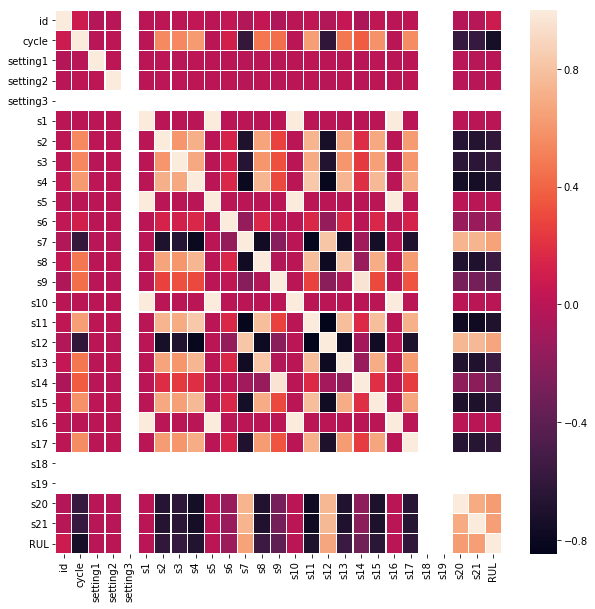

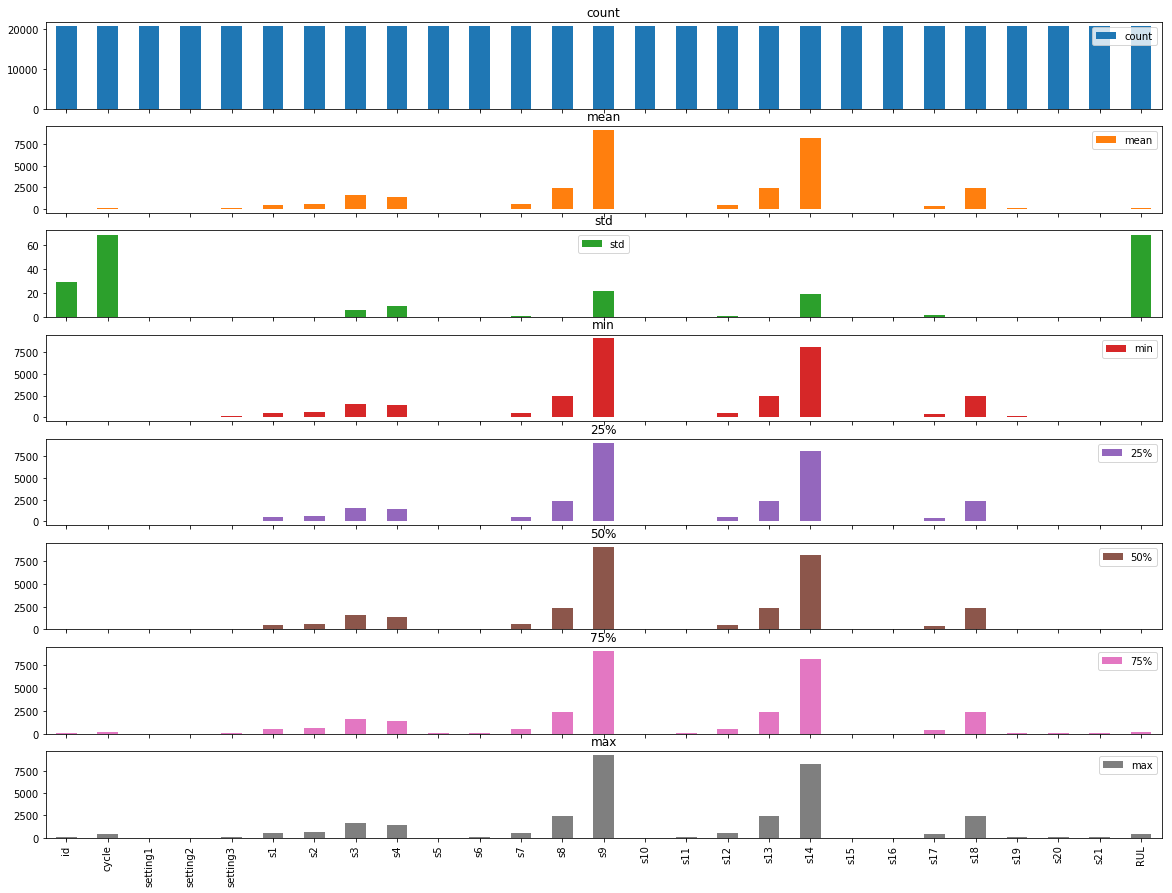

In [174]:
# Train-test split, normalization and feature engineering
X_train_transformed, X_test_transformed, y_train, y_test = feature_engineering(df_cleaned)

In [175]:
def LSTM_model(X_train_normalized, y_train, X_test_normalized, y_test):
    epochs = 20
    # Defining a 2-layer stacked LSTM
    X_train_lstm = numpy.reshape(X_train_normalized,(X_train_normalized.shape[0],1,-1)) 
    print("Shape of X_train = "+str(X_train_lstm.shape))
    X_test_lstm = numpy.reshape(X_test_normalized,(X_test_normalized.shape[0],1,-1))
    print("Shape of X_train = "+str(X_test_lstm.shape))
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train_normalized.shape[1]), return_sequences = True))
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train_normalized.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train_lstm, y_train, epochs=epochs, validation_split=0.20)
    y_train_pred_lstm = model.predict(X_train_lstm)
    y_test_pred_lstm = model.predict(X_test_lstm)
    R2_test_lstm = r2_score(y_test_pred_lstm, y_test)
    R2_train_lstm = r2_score(y_train_pred_lstm,y_train)
    print("\nR2 Score on the test dataset with LSTM = " + str(R2_test_lstm))
    #model.save("Model/lstm_model")
    #reconstructed_model = keras.models.load_model("Model/lstm_model")
    return (epochs, history, model, R2_test_lstm, R2_train_lstm)

In [176]:
# Fitting LSTM model
print("2. Using LSTM:\n")
epochs, history, model, R2_test_lstm, R2_train_lstm = LSTM_model(X_train_transformed, y_train, X_test_transformed, y_test)

2. Using LSTM:

Shape of X_train = (16504, 1, 27)
Shape of X_train = (4127, 1, 27)
Epoch 1/20
413/413 [==============================] - 2s 5ms/step - loss: 4472.1567 - val_loss: 1784.1134
Epoch 2/20
413/413 [==============================] - 1s 3ms/step - loss: 1792.7694 - val_loss: 1728.6608
Epoch 3/20
413/413 [==============================] - 1s 4ms/step - loss: 1748.0912 - val_loss: 1716.1306
Epoch 4/20
413/413 [==============================] - 1s 3ms/step - loss: 1741.0769 - val_loss: 1678.7426
Epoch 5/20
413/413 [==============================] - 1s 3ms/step - loss: 1732.3860 - val_loss: 1679.9825
Epoch 6/20
413/413 [==============================] - 1s 3ms/step - loss: 1729.8440 - val_loss: 1691.8402
Epoch 7/20
413/413 [==============================] - 1s 3ms/step - loss: 1729.1775 - val_loss: 1675.6713
Epoch 8/20
413/413 [==============================] - 1s 3ms/step - loss: 1724.4082 - val_loss: 1750.9050
Epoch 9/20
413/413 [==============================] - 2s 4ms/step - l

In [177]:
if not os.path.exists("/output"):
    os.makedirs("/output")

In [178]:
model.save(os.path.join("/output", 'saved_model.h5'))

In [179]:
R2_test_lstm

0.4796424273772305

In [180]:
R2_train_lstm

0.4751792732223855

In [181]:
history.history['loss'][-1]

1705.1158447265625

In [182]:
history.history['val_loss']

[1784.1134033203125,
 1728.6607666015625,
 1716.130615234375,
 1678.7425537109375,
 1679.9825439453125,
 1691.8402099609375,
 1675.6712646484375,
 1750.905029296875,
 1662.48486328125,
 1678.4327392578125,
 1658.0599365234375,
 1656.4307861328125,
 1652.5123291015625,
 1654.966064453125,
 1661.99853515625,
 1677.258544921875,
 1650.517578125,
 1654.014892578125,
 1652.7056884765625,
 1649.1395263671875]

In [183]:
epochs

20